<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 128
learning_rate = 1e-4
num_epochs = 10
blockSize = 32
testBlockSize = 400
numVars = 1
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation, lossFunc, relativeErr
import random
import json

files = glob.glob("/content/drive/MyDrive/Colab Notebooks/STAT946_proj/data/1_var_train.json")
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 498795 examples, 27 unique.
id:122392
outputs:C*x1*C*log(C*x1+C)/(C*x1+C)+C>_______
variables:1


In [33]:
files = glob.glob("/content/drive/MyDrive/Colab Notebooks/STAT946_proj/data/1_var_test.json")
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 967 examples, 27 unique.
tensor(-2.8960) tensor(2.7517)
id:52
outputs:C*log(C*cos(C*x1))+C>________________
variables:1


In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from utils import get_predicted_skeleton


# from SymbolicGPT: https://github.com/mojivalipour/symbolicgpt/blob/master/models.py
class PointNetConfig:
    """base PointNet config"""

    def __init__(
        self,
        embeddingSize,
        numberofPoints,
        numberofVars,
        numberofYs,
        method="GPT",
        varibleEmbedding="NOT_VAR",
        **kwargs,
    ):
        self.embeddingSize = embeddingSize
        self.numberofPoints = numberofPoints  # number of points
        self.numberofVars = numberofVars  # input dimension (Xs)
        self.numberofYs = numberofYs  # output dimension (Ys)
        self.method = method
        self.varibleEmbedding = varibleEmbedding

        for k, v in kwargs.items():
            setattr(self, k, v)


class tNet(nn.Module):
    """
    The PointNet structure in the orginal PointNet paper:
    PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation by Qi et. al. 2017
    """

    def __init__(self, config):
        super(tNet, self).__init__()

        self.activation_func = F.relu
        self.num_units = config.embeddingSize

        self.conv1 = nn.Conv1d(
            config.numberofVars + config.numberofYs, self.num_units, 1
        )
        self.conv2 = nn.Conv1d(self.num_units, 2 * self.num_units, 1)
        self.conv3 = nn.Conv1d(2 * self.num_units, 4 * self.num_units, 1)
        self.fc1 = nn.Linear(4 * self.num_units, 2 * self.num_units)
        self.fc2 = nn.Linear(2 * self.num_units, self.num_units)

        # self.relu = nn.ReLU()

        self.input_batch_norm = nn.BatchNorm1d(config.numberofVars + config.numberofYs)
        # self.input_layer_norm = nn.LayerNorm(config.numberofPoints)

        self.bn1 = nn.BatchNorm1d(self.num_units)
        self.bn2 = nn.BatchNorm1d(2 * self.num_units)
        self.bn3 = nn.BatchNorm1d(4 * self.num_units)
        self.bn4 = nn.BatchNorm1d(2 * self.num_units)
        self.bn5 = nn.BatchNorm1d(self.num_units)

    def forward(self, x):
        """
        :param x: [batch, #features, #points]
        :return:
            logit: [batch, embedding_size]
        """
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4 * self.num_units

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        # x = self.fc2(x)

        return x


class NoisePredictionTransformer(nn.Module):
    def __init__(self, n_embd, max_seq_len, n_layer=6, n_head=8, max_timesteps=1000):
        super().__init__()
        self.pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, n_embd))
        self.time_emb = nn.Embedding(max_timesteps, n_embd)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_embd,
            nhead=n_head,
            dim_feedforward=n_embd * 4,
            activation="gelu",
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layer)

    def forward(self, x_t, t, condition):
        _, L, _ = x_t.shape
        pos_emb = self.pos_emb[:, :L, :]  # [1, L, n_embd]
        time_emb = self.time_emb(t)
        if time_emb.dim() == 1:  # Scalar t case, [n_embd]
            time_emb = time_emb.unsqueeze(0)  # [1, n_embd]
        time_emb = time_emb.unsqueeze(1)  # [1, 1, n_embd]
        condition = condition.unsqueeze(1)  # [B, 1, n_embd]

        x = x_t + pos_emb + time_emb + condition
        return self.encoder(x)


# influenced by https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/simple_diffusion.py
class SymbolicGaussianDiffusion(nn.Module):
    def __init__(
        self,
        tnet_config,
        vocab_size,
        max_seq_len,
        padding_idx: int = 0,
        max_num_vars: int = 9,
        n_layer=6,
        n_head=8,
        n_embd=512,
        timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        ce_weight=1.0,  # Weight for CE loss relative to MSE
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.padding_idx = padding_idx
        self.n_embd = n_embd
        self.timesteps = timesteps
        self.ce_weight = ce_weight

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.tok_emb = nn.Embedding(vocab_size, n_embd, padding_idx=self.padding_idx)
        self.vars_emb = nn.Embedding(max_num_vars, n_embd)

        self.decoder = nn.Linear(n_embd, vocab_size, bias=False)
        self.decoder.weight = self.tok_emb.weight

        self.tnet = tNet(tnet_config)
        self.model = NoisePredictionTransformer(
            n_embd, max_seq_len, n_layer, n_head, timesteps
        )

        # Noise schedule
        self.register_buffer("beta", torch.linspace(beta_start, beta_end, timesteps))
        self.register_buffer("alpha", 1.0 - self.beta)
        self.register_buffer("alpha_bar", torch.cumprod(self.alpha, dim=0))

    def q_sample(self, x_start, t, noise=None):
        noise = torch.randn_like(x_start)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t]).view(-1, 1, 1)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1)

        x_t = sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise
        return x_t

    def p_mean_variance(self, x, t, t_next, condition):
        alpha_t = self.alpha[t]
        alpha_bar_t = self.alpha_bar[t]
        alpha_bar_t_next = self.alpha_bar[t_next]
        beta_t = self.beta[t]

        x_start_pred = self.model(x, t.long(), condition)

        coeff1 = torch.sqrt(alpha_bar_t_next) * beta_t / (1 - alpha_bar_t)
        coeff2 = torch.sqrt(alpha_t) * (1 - alpha_bar_t_next) / (1 - alpha_bar_t)
        mean = coeff1 * x_start_pred + coeff2 * x
        variance = (1 - alpha_bar_t_next) / (1 - alpha_bar_t) * beta_t
        return mean, variance

    @torch.no_grad()
    def p_sample(self, x, t, t_next, condition):
        mean, variance = self.p_mean_variance(x, t, t_next, condition)
        if torch.all(t_next == 0):
            return mean
        noise = torch.randn_like(x)
        return mean + torch.sqrt(variance) * noise

    @torch.no_grad()
    def sample(self, points, variables, train_dataset, batch_size=16):
        condition = self.tnet(points) + self.vars_emb(variables)
        shape = (batch_size, self.max_seq_len, self.n_embd)
        x = torch.randn(shape, device=self.device)
        steps = torch.arange(self.timesteps - 1, -1, -1, device=self.device)

        for i in tqdm(
            range(self.timesteps), desc="sampling loop", total=self.timesteps
        ):
            t = steps[i]
            t_next = (
                steps[i + 1]
                if i + 1 < self.timesteps
                else torch.tensor(0, device=self.device)
            )
            x = self.p_sample(x, t, t_next, condition)

            # Print prediction every 250 steps
            #if (i + 1) % 250 == 0:
            #    logits = self.decoder(x)  # [B, L, vocab_size]
            #    token_indices = torch.argmax(logits, dim=-1)  # [B, L]
            #    for j in range(batch_size):
            #       token_indices_j = token_indices[j]  # [L]
            #        predicted_skeleton = get_predicted_skeleton(
            #            token_indices_j, train_dataset
            #        )
            #        tqdm.write(f" sample {j}: predicted_skeleton: {predicted_skeleton}")

        logits = self.decoder(x)  # [B, L, vocab_size]
        token_indices = torch.argmax(logits, dim=-1)  # [B, L]
        predicted_skeletons = []
        for j in range(batch_size):
            token_indices_j = token_indices[j]  # [L]
            predicted_skeleton = get_predicted_skeleton(token_indices_j, train_dataset)
            predicted_skeletons.append(predicted_skeleton)
        return predicted_skeletons

    def p_losses(
        self, x_start, points, tokens, variables, t, noise=None, mse: bool = False
    ):
        """Hybrid loss: MSE on embeddings + CE on tokens."""
        noise = torch.randn_like(x_start)
        x_t = self.q_sample(x_start, t, noise)
        condition = self.tnet(points) + self.vars_emb(variables)
        x_start_pred = self.model(x_t, t.long(), condition)

        # MSE loss on embeddings
        if mse:
            mse_loss = F.mse_loss(x_start_pred, x_start)
        else:
            mse_loss = torch.tensor(0.0, device=self.device)

        # CE loss on tokens
        logits = self.decoder(x_start_pred)  # [B, L, vocab_size]
        ce_loss = F.cross_entropy(
            logits.view(-1, self.vocab_size),  # [B*L, vocab_size]
            tokens.view(-1),  # [B*L]
            ignore_index=self.padding_idx,
            reduction="mean",
        )

        total_loss = mse_loss + self.ce_weight * ce_loss
        return total_loss, mse_loss, ce_loss

    def forward(self, points, tokens, variables, t, mse=False):
        token_emb = self.tok_emb(tokens)
        total_loss, mse_loss, ce_loss = self.p_losses(
            token_emb, points, tokens, variables, t, mse=mse
        )
        return total_loss, mse_loss, ce_loss


In [27]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton

            # Fit constants
            c = [1.0 for _ in range(predicted.count("C"))]
            if c:
                try:
                    cHat = minimize(lossFunc, c, args=(predicted, t["X"], t["Y"]))
                    if cHat.success and cHat.fun != float(
                        "inf"
                    ):  # Check if optimization succeeded and equation is valid
                        predicted = predicted.replace("C", "{}").format(*cHat.x)
                    else:
                        print(
                            f"Skipping sample {batch_idx * B + i + 1}: Invalid predicted equation or optimization failed\n"
                        )
                        continue
                except Exception as e:
                    print(
                        f"Skipping sample {batch_idx * B + i + 1}: Error fitting constants: {e}\n"
                    )
                    continue

            # Evaluate both equations
            Ys = []
            Yhats = []
            valid_sample = True
            for xs in t["XT"]:
                # Target evaluation
                try:
                    eqTmp = eq.replace(" ", "").replace("\n", "")
                    for j, x in enumerate(xs):
                        eqTmp = eqTmp.replace("x{}".format(j + 1), f"({x})")
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    Ys.append(YEval)
                except Exception as e:
                    print(
                        f"Skipping sample {batch_idx * B + i + 1}: TA: Invalid target equation. Eq: {eqTmp}, Reason: {e}\n"
                    )
                    valid_sample = False
                    break

                # Predicted evaluation
                try:
                    eqTmp = predicted.replace(" ", "").replace("\n", "")
                    for j, x in enumerate(xs):
                        eqTmp = eqTmp.replace("x{}".format(j + 1), f"({x})")
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhats.append(Yhat)
                except Exception as e:
                    print(
                        f"Skipping sample {batch_idx * B + i + 1}: PR: Invalid predicted equation. Eq: {eqTmp}, Reason: {e}\n"
                    )
                    valid_sample = False
                    break

            if not valid_sample:
                continue

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(predicted)
            results["error"].append(err)

            #print(f"\nSample {batch_idx * B + i + 1}:")
            #print(f"Target: {eq}")
            #print(f"Target Skeleton: {eq_skeleton}")
            #print(f"Predicted Skeleton: {predicted_skeleton}")
            #print(f"Predicted: {predicted}")
            #print(f"Relative Error: {err:.6f}")
            #print("-" * 50)

    return results


In [34]:
import numpy as np
from matplotlib import pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='SymbolicGPT'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    fName = 'results_symbolic_diffusion_119.txt'
    modelKey = 'SymbolicDiffusion'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()

{0: '(', 1: ')', 2: '*', 3: '**', 4: '+', 5: '/', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: '<', 18: '>', 19: 'C', 20: 'T', 21: '_', 22: 'cos', 23: 'exp', 24: 'log', 25: 'sin', 26: 'x1'}


sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


Skipping sample 1: PR: Invalid predicted equation. Eq: 1.0*(-3.17441699)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 2: PR: Invalid predicted equation. Eq: 1.0*exp(1.0*(4.60700177)1.0+1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 3: TA: Invalid target equation. Eq: 0.5035538309121157*(-3.07921534)**5+-1.7880275308333555*(-3.07921534)**4+1.9763031036747143*(-3.07921534)**3+0.64126273976877*(-3.07921534)**2*1.9018843748420244*log(0.8634365809569955*(-3.07921534))+-1.6578296868442013*(-3.07921534)**2+-0.4515420744032035*(-3.07921534)+1.133184078275951, Reason: math domain error

Skipping sample 4: PR: Invalid predicted equation. Eq: 1.0*log(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:-12.424338916795254,54.32072288990079, Err:18.80003712884359
yPR,yTrue:-17.05507546469526,59.38645754043692, Err:24.659212548819678
yPR,yTrue:-17.05507546469526,59.38645754043692, Err:24.659212548819678
yPR,yTrue:-7.772203209696432,42.84267

sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:161: RuntimeWarning: invalid value encountered in scalar divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_dcsrch.py:404: RuntimeWarning: invalid value encountered in scalar multiply
  fxm = self.fx - self.stx * self.gtest
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_dcsrch.py:405: RuntimeWarning: invalid value encountered in scalar multiply
  fym = self.fy - self.sty * self.gtest
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_dcsrch.py:407: RuntimeWarning: invalid value encountered in scalar subtract
  gxm = self.gx - self.gtest
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_dcsrch.py:408: RuntimeWarning: invalid value encountered in scalar subtract
  gym = self.gy - self.gtest
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_dcsrch.py:431: RuntimeW

yPR,yTrue:0.7408687814449649,0.7408687755171806, Err:8.659184924237596e-18
yPR,yTrue:0.7408687814449649,0.7408687755171806, Err:8.659184924237596e-18
yPR,yTrue:0.7408687814449649,0.7408687755171806, Err:8.659184924237596e-18
yPR,yTrue:0.7408687814449649,0.7408687755171806, Err:8.659184924237596e-18
yPR,yTrue:0.7408687814449649,0.7408687755171806, Err:8.659184924237596e-18


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:395: RuntimeWarning: invalid value encountered in scalar divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Skipping sample 130: Invalid predicted equation or optimization failed

yPR,yTrue:-74.02643488248388,-74.02643617009176, Err:6.68523316759808e-15
yPR,yTrue:43.693682250470175,43.69368300438489, Err:2.291889890366775e-15
yPR,yTrue:60.48767841468501,60.4876794598441, Err:4.4046775506063075e-15
yPR,yTrue:-49.02733213756173,-49.02733299163084, Err:2.941273063738754e-15
yPR,yTrue:39.50169368671891,39.501694367935436, Err:1.8711976514647078e-15
yPR,yTrue:-0.5066802339038472,-0.5066802621277113, Err:3.5245629739786105e-17
yPR,yTrue:4.693375497397229,4.693375801780157, Err:4.099330265921156e-15
yPR,yTrue:4.9666351602649,4.966635482126105, Err:4.583630444519078e-15
yPR,yTrue:4.8620814614084695,4.862081776582194, Err:4.3951361875851285e-15
yPR,yTrue:5.602739038576883,5.602739401124666, Err:5.8157112567599634e-15
Skipping sample 133: PR: Invalid predicted equation. Eq: 1.0*(4.15515306)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:23.437135446576427,-15.283754263518928, Err:5.38

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 165: TA: Invalid target equation. Eq: 0.1378417083340988*log(0.5882399719244167*(-4.12670666))+1.504473998829472, Reason: math domain error

Skipping sample 166: TA: Invalid target equation. Eq: 0.9713341343072965*(-3.74567178)*-0.14775141384564638*log(1.20616961451594*(-3.74567178)+0.9104998006330018)*-1.3613506881299762*cos(0.3127410139801876*(-3.74567178)+0.601443304751557)+-1.3506849356373345*(-3.74567178)+-0.7614533371646843, Reason: math domain error

Skipping sample 167: TA: Invalid target equation. Eq: 0.2708758220378855*(3.86753865)**2+0.2655535429570768*(3.86753865)*0.8595744090638022*log(-1.917994105680095*(3.86753865))+-1.9703680123135814*(3.86753865)+1.7630679214963294, Reason: math domain error

Skipping sample 168: PR: Invalid predicted equation. Eq: 1.0*sin(1.0*(3.42847942))+), Reason: unmatched ')' (<string>, line 1)

yPR,yTrue:4.185807335108523,4.1858149702798695, Err:2.5058462218838403e-12
yPR,yTrue:-2.0362119446056344,-2.0362151347599746, Err:4.37461

sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Skipping sample 257: PR: Invalid predicted equation. Eq: 1.0*(4.38360835)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 258: TA: Invalid target equation. Eq: 0.5489857163403724*log(0.6268040365231822*(-4.67051946))+-2.043103910965079, Reason: math domain error

Skipping sample 259: PR: Invalid predicted equation. Eq: 1.0*(4.73957131)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 260: TA: Invalid target equation. Eq: -0.6894762711194902*(4.16277098)**2+-1.266029662627414*log(-0.26586121798004103*(4.16277098))+0.10266145852190789, Reason: math domain error

yPR,yTrue:4145.818130626981,-6992.87631879866, Err:3438.54245783989
yPR,yTrue:-2352.264963419204,-3546.9462418254316, Err:39.55577753135981
yPR,yTrue:1149.1090507782076,-1496.5418743726734, Err:193.98622548512245
yPR,yTrue:-649.5583551043217,-758.0492933770271, Err:0.3262065972200854
yPR,yTrue:1724.9356139762715,-2438.889940424488, Err:480.4972009606893
Skipping sample 262: PR: Invalid p

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 345: TA: Invalid target equation. Eq: -0.9973801111696041*log(1.5650404605055863*sin(-1.6212458929254705*(4.62650975)))+0.36571217600020045, Reason: math domain error

yPR,yTrue:16.637275841017257,11.243530411375737, Err:0.4705176598102855
yPR,yTrue:11.897600676270413,8.636686818177827, Err:0.17197831559962284
yPR,yTrue:12.408232465981053,8.917536699914704, Err:0.19706932845945305
yPR,yTrue:9.98420522470849,7.584310336502918, Err:0.09314927511174281
yPR,yTrue:23.522176215114225,15.030257941463594, Err:1.1662902631750498
yPR,yTrue:0,-0.8050808924849504, Err:0.14698881424133592
yPR,yTrue:0,-0.8050808924849504, Err:0.14698881424133592
yPR,yTrue:0,-0.8050808924849504, Err:0.14698881424133592
yPR,yTrue:0,-0.8050808924849504, Err:0.14698881424133592
yPR,yTrue:0,-0.8050808924849504, Err:0.14698881424133592
Skipping sample 348: TA: Invalid target equation. Eq: 0.30420842002725124*log(1.1612163563132172*(-4.9626909))/0.24422867020288264*sin(-0.38590987755554584*(-4.9626909))+0.3

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 363: Invalid predicted equation or optimization failed

Skipping sample 364: PR: Invalid predicted equation. Eq: 1.0*exp(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:-0.19875378269510358,-2.9518708020496707, Err:0.6080116703025452
yPR,yTrue:0.2914307982442008,-2.045577998713156, Err:0.43811010195681493
yPR,yTrue:0.5542279598333586,-2.0278764545550483, Err:0.5348231200509685
yPR,yTrue:-0.29372946426593716,-1.4285548500001375, Err:0.10330483717024638
yPR,yTrue:-0.7773558143102962,-2.525501626775778, Err:0.24514208827811304
Skipping sample 366: PR: Invalid predicted equation. Eq: 1.0*(4.06671772)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:1.4106948176654472,1.7257193025876356, Err:0.013007627786524532
yPR,yTrue:0.3650063083433748,0.8944852230859257, Err:0.0367457250278525
yPR,yTrue:1.8294189363093945,2.215048170342763, Err:0.019491684823022815
yPR,yTrue:1.7738746973477628,0.21392471421460113, Err:0.3189560382108811
yPR,yTrue:1.331870

sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


Skipping sample 385: PR: Invalid predicted equation. Eq: 1.0*sin(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:-3.0948244008199848,0.6351567525478223, Err:1.563896411240411
yPR,yTrue:2.355050438486714,-1.1687150045113297, Err:1.395753393926544
yPR,yTrue:2.9798002015404226,-2.2125807052097386, Err:3.0305942627401388
yPR,yTrue:2.355050438486714,-1.1687150045113297, Err:1.395753393926544
yPR,yTrue:3.166031619674916,-2.314518564714194, Err:3.3763155261953144
yPR,yTrue:-4.184046212681085,-6.15370729289802, Err:0.11338821846965753
yPR,yTrue:-4.026017642681084,-5.922291505183231, Err:0.10509620709850516
yPR,yTrue:-3.1404857826810844,-4.625525655005366, Err:0.06445567390785553
yPR,yTrue:-2.753132872681084,-4.058289118021795, Err:0.04978630972450026
yPR,yTrue:5.084446397318915,7.418999960428707, Err:0.1592915030273636
yPR,yTrue:3.0959235740763242,5.407687046116491, Err:0.13795065031875978
yPR,yTrue:-5.029327455923676,-8.673308074564293, Err:0.3427591637285095
yPR,yTrue:3.15437

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 448: Invalid predicted equation or optimization failed

yPR,yTrue:(5.289683473483633+0j),5.43570643038843, Err:(0.000379927090662204-0j)
yPR,yTrue:(9.321849126254243+0j),9.647277984285624, Err:(0.0018869922193704553-0j)
yPR,yTrue:(12.746925195008394+0j),13.251427912258958, Err:(0.004535080541648815-0j)
yPR,yTrue:(7.312990231409027-1.648963055885741j),7.103320878086235, Err:(-0.04766514471956404-0.012320656852288397j)
yPR,yTrue:(7.974804883551037-1.7858689076695267j),7.78879653885183, Err:(-0.05621082961271227-0.011837772375939574j)
Skipping sample 450: TA: Invalid target equation. Eq: 0.09386117776299052*(4.30411638)+-1.2347517780405868*(4.30411638)/(0.1089793798391061*(4.30411638)+-1.421019424077011)+0.43078439450214745*log(-1.0422571400118166*sin(2.0453074016640698*(4.30411638)+-1.9769485857076359))+-0.7885904333203311, Reason: math domain error

Skipping sample 451: PR: Invalid predicted equation. Eq: 1.0*log(1.0*(-3.33452173))+1.0, Reason: math domain error

Skippin

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

yPR,yTrue:-0.29281750804271256,3.0232338113864707, Err:0.4109168239018687
yPR,yTrue:25.57848752775106,6.292872595560384, Err:13.898835624308495
yPR,yTrue:25.810369956933044,6.305439338256064, Err:14.216747696314188
yPR,yTrue:-0.31208695368918116,3.5369290391954094, Err:0.5536188485165939
yPR,yTrue:13.747009612652734,5.920412980860907, Err:2.28906086128729
Skipping sample 506: TA: Invalid target equation. Eq: 0.7667647796954329*log(-1.6009134027883891*(-3.09337778)**4+1.9950593860511447*(-3.09337778)**3+0.29686955421344097*(-3.09337778)**2+-1.3194587250840115*(-3.09337778)+0.9588362269055422)+0.28810099956901736, Reason: math domain error

yPR,yTrue:-12.58172006604295,-10.82544792360656, Err:0.03177409612418106
yPR,yTrue:-22.095585713470737,-19.21638288993699, Err:0.08539532558940782
yPR,yTrue:-31.18481809590246,-24.588699033902135, Err:0.4481945301506326
yPR,yTrue:-24.675389531500944,-21.289121301101353, Err:0.11812240803673316
yPR,yTrue:-11.177193037937721,-9.823737218301417, Err:0.01

sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perh

yPR,yTrue:-2.773572252082268,5.537049283426276, Err:1.4260821814483267
yPR,yTrue:3.0889644174832527,6.762807436388962, Err:0.2786882983813541
yPR,yTrue:2.809110268379932,5.668573108389861, Err:0.16882877043127129
yPR,yTrue:-2.773572252082268,5.537049283426276, Err:1.4260821814483267
yPR,yTrue:-2.961514244782845,6.251598450103084, Err:1.7526302788040775
Skipping sample 514: TA: Invalid target equation. Eq: -0.49122815416635524*sin(-0.7699440900223671*log(1.38548389024339*(-4.59408016)+-1.5293409374507783))+-1.4305087201815025, Reason: math domain error

yPR,yTrue:1.8086372114564233,1.5477657919283856, Err:0.0055867302953899614
yPR,yTrue:1.8019138240154968,2.302287681471495, Err:0.02055388517506748
yPR,yTrue:1.8885362120515585,1.6914828171822087, Err:0.0031876640592729895
yPR,yTrue:1.8954834190172414,2.6670530050738046, Err:0.04887141385881722
yPR,yTrue:1.8086372114564233,1.5477657919283856, Err:0.0055867302953899614
Skipping sample 516: PR: Invalid predicted equation. Eq: 1.0*sin(1.0, R

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

yPR,yTrue:-232.05185456377998,-232.05192965120526, Err:5.924940276231976e-12
yPR,yTrue:-64.4394289321984,-64.43943841060525, Err:9.441048842826273e-14
yPR,yTrue:-132.25777368233716,-132.257806184137, Err:1.1101058063534097e-12
yPR,yTrue:-1.1912440288460995,-1.191244339335049, Err:1.013075580873827e-16
yPR,yTrue:-232.05185456377998,-232.05192965120526, Err:5.924940276231976e-12
Skipping sample 548: PR: Invalid predicted equation. Eq: 1.0/(4.92909911)1.01.01.0(4.92909911), Reason: invalid syntax (<string>, line 1)

yPR,yTrue:5.022158170447378,5.739000423458233, Err:0.017652927654211826
yPR,yTrue:4.212975357304371,4.718768581653962, Err:0.00878851631934906
yPR,yTrue:-5.041637714163117,-6.949609423577463, Err:0.12505855632157148
yPR,yTrue:3.4729894867420614,3.7857814551719544, Err:0.0033610945942612637
yPR,yTrue:-3.906278012792711,-5.518128056912839, Err:0.08925217740811646
Skipping sample 550: PR: Invalid predicted equation. Eq: 1.0*exp(1.0, Reason: '(' was never closed (<string>, line 1)

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 563: PR: Invalid predicted equation. Eq: 1.0/(-3.0604161)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:-1.86320882678491,-1.8632085385144583, Err:8.142926131174722e-15
yPR,yTrue:-1.86320882678491,-1.8632085385144583, Err:8.142926131174722e-15
yPR,yTrue:-1.86320882678491,-1.8632085385144583, Err:8.142926131174722e-15
yPR,yTrue:-1.86320882678491,-1.8632085385144583, Err:8.142926131174722e-15
yPR,yTrue:-1.86320882678491,-1.8632085385144583, Err:8.142926131174722e-15
Skipping sample 565: TA: Invalid target equation. Eq: -0.3610163891553415*log(-0.06917516508064248*log(1.0959495226730045*(-3.35723817)+-0.14158237985262168))+0.02273761540270991, Reason: math domain error

yPR,yTrue:1.2745917228020596,1.274591729946461, Err:7.311333205488126e-18
yPR,yTrue:1.2745917228020596,1.274591729946461, Err:7.311333205488126e-18
yPR,yTrue:1.2745917228020596,1.274591729946461, Err:7.311333205488126e-18
yPR,yTrue:1.2745917228020596,1.274591729946461, Err:7.31133320548812

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 576: TA: Invalid target equation. Eq: -0.41073726159597657*log(-2.017298275394372*(3.62333782))+-0.5990111942702672, Reason: math domain error

Skipping sample 577: PR: Invalid predicted equation. Eq: 1.0*(3.13785106)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:-78.56323116142792,-59.82445991035494, Err:0.5436387112497052
yPR,yTrue:-78.56323116142792,-59.82445991035494, Err:0.5436387112497052
yPR,yTrue:-189.31574168420107,-114.66358417865678, Err:8.62805455083568
yPR,yTrue:-287.0462757082063,-156.2296898752131, Err:26.494380890899574
yPR,yTrue:-332.9982559309724,-174.48738987487692, Err:38.8996982580014
yPR,yTrue:-2.9775316514296715,-2.9775314156186266, Err:4.534664051832655e-15
yPR,yTrue:-2.991792614676876,-2.9917923748058035, Err:4.692157548326911e-15
yPR,yTrue:-0.4363022824752185,-0.43630277013995444, Err:1.9393649243518117e-14
yPR,yTrue:-0.356821114305367,-0.35682162459800915, Err:2.1235155488943024e-14
yPR,yTrue:-0.323658387256883,-0.32365890699

sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


yPR,yTrue:-0.3944854895550031,-0.5530539854552229, Err:0.007157257251089254
yPR,yTrue:0.7771430503183884,0.8692168643209012, Err:0.0024131542363613405
yPR,yTrue:-0.11682425545558779,0.006770710204077348, Err:0.004348248703543256
yPR,yTrue:0.38693533664105045,0.6270746477626176, Err:0.016414941324953306
yPR,yTrue:0.49784830814669995,0.7388177943235144, Err:0.016528632247808987
Skipping sample 642: PR: Invalid predicted equation. Eq: 1.0*(3.95130247)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:5.2510665897613595,5.251073569390122, Err:1.940368094894284e-12
yPR,yTrue:-4.520396082609167,-4.520400029659554, Err:6.205329092243367e-13
yPR,yTrue:4.4122339403056205,4.412239981932005, Err:1.453875464353783e-12
yPR,yTrue:-3.1738777480347107,-3.173880189376659, Err:2.3739780796581596e-13
yPR,yTrue:5.544061241902459,5.5440685491647255, Err:2.126810852125908e-12
yPR,yTrue:208.26121948622927,200.47540451151522, Err:0.018862594712984012
yPR,yTrue:619.0236841981158,604.7672759761311

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 683: PR: Invalid predicted equation. Eq: 1.0*sin(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 684: Invalid predicted equation or optimization failed

yPR,yTrue:-0.4341644422945336,-0.2062823632151064, Err:0.005513421810663174
yPR,yTrue:0.2536098798820025,-0.9520788084824252, Err:0.15433742376717133
yPR,yTrue:-0.4115852344259169,-0.6827341840168031, Err:0.00780578754223227
yPR,yTrue:-0.281551250236016,-0.8173648754484604, Err:0.03048094167818766
yPR,yTrue:0.35055868191807593,-2.9669884418720796, Err:1.1685171067877607
yPR,yTrue:-4555.6990111847945,-4555.698987582066, Err:9.30907534733081e-15
yPR,yTrue:-6354.435415844965,-6354.435382926413, Err:1.810771259563359e-14
yPR,yTrue:-1122.723382199328,-1122.7233763763015, Err:5.666040292430075e-16
yPR,yTrue:-6354.435415844965,-6354.435382926413, Err:1.810771259563359e-14
yPR,yTrue:-10112.687907221609,-10112.687854838714, Err:4.585230042508451e-14
yPR,yTrue:-1.5559531950239154,-2.6593049187513205, Err:0.0

sampling loop: 100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


Skipping sample 769: PR: Invalid predicted equation. Eq: 1.0*(-3.56412829)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 770: PR: Invalid predicted equation. Eq: 1.0*log(1.0*(-3.86839224))+1.0, Reason: math domain error

yPR,yTrue:-4303.208200218093,-10244.626465150166, Err:490.9106168722772
yPR,yTrue:-5056.184066668009,-12524.425962628053, Err:775.6377238497835
yPR,yTrue:-8644.383017761967,-24383.63083839914, Err:3445.007072204909
yPR,yTrue:-2941.6037432277494,-6369.459356913784, Err:163.4057037472149
yPR,yTrue:-923.9747773418366,-1480.223388109858, Err:4.30288807313508
yPR,yTrue:-82.43786522559857,-42.2125688491087, Err:10.439197573664698
yPR,yTrue:-40.83353902656706,-27.615754720947898, Err:1.1271609464297823
yPR,yTrue:28.859314142237842,-16.422893595503538, Err:13.228901946397654
yPR,yTrue:20.515063958818885,-13.087583841332515, Err:7.284766099425259
yPR,yTrue:-31.983242362467234,-23.89748682308511, Err:0.4218031569357539
Skipping sample 773: PR: Invalid pre

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

yPR,yTrue:10.207833746066633,10.20782526985297, Err:1.5035993353761807e-12
yPR,yTrue:8.09216003670778,8.092153463625936, Err:9.042039785621518e-13
yPR,yTrue:-5.401716017014554,-5.401710451823472, Err:6.481693560927791e-13
yPR,yTrue:9.483212814230479,9.48320498984188, Err:1.2812360709293255e-12
yPR,yTrue:-5.931906526593173,-5.931900484474848, Err:7.64023621105075e-13
Skipping sample 877: PR: Invalid predicted equation. Eq: 1.0*(4.51390512)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 878: PR: Invalid predicted equation. Eq: 1.0*log(1.0*(-3.63132367))+1.0, Reason: math domain error

Skipping sample 879: PR: Invalid predicted equation. Eq: 1.0*log(1.0*(-3.17856567))+1.0, Reason: math domain error

yPR,yTrue:-222.06270481019774,-139.8362971651489, Err:10.441871226387523
yPR,yTrue:-126.09026929509592,-93.44503187956764, Err:1.6458693657587782
yPR,yTrue:126.39911075852955,32.965148269549495, Err:13.482338725057852
yPR,yTrue:-316.4767862959174,-179.4608699693265, Err:

sampling loop: 100%|██████████| 1000/1000 [00:42<00:00, 23.43it/s]
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perh

yPR,yTrue:-3.855349393885805,-3.855349331751115, Err:1.85375384081787e-16
yPR,yTrue:-4.596420086720848,-4.596420014051995, Err:2.5355979390600327e-16
yPR,yTrue:3.119616786440587,3.119616749427621, Err:6.577965104308269e-17
yPR,yTrue:3.09237722519883,3.092377188573069, Err:6.44105643649834e-17
yPR,yTrue:4.071602502049826,4.071602451504586, Err:1.2267168027890584e-16
Skipping sample 492: TA: Invalid target equation. Eq: -0.617883260658711*log(1.2724067107866763*(-4.89169428))+-1.4201974416846261, Reason: math domain error

yPR,yTrue:3.593622188285834,3.593622187858237, Err:1.0695376585836914e-20
yPR,yTrue:-1.6952845902712748,-1.6952845748809104, Err:1.3855571462916046e-17
yPR,yTrue:-2.344560874505895,-2.3445608571736876, Err:1.7572533804334152e-17
yPR,yTrue:3.593622188285834,3.593622187858237, Err:1.0695376585836914e-20
yPR,yTrue:4.180088601808727,4.180088599627137, Err:2.7840236358763214e-19
Skipping sample 494: PR: Invalid predicted equation. Eq: 1.0*log(1.0*(-3.69616568))+1.0, Reason:

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


Test Case 0.
Target:0.9633718254570423*x1*1.9148717606989867*log(0.9006877952636358*x1**4+1.6669653267307702*x1**3+0.5648574464503451*x1**2+-1.2276559446229411*x1+-0.6261005199630683)*-1.7718715377928107*sin(1.342774419612362*x1)+0.6767932552032421
Skeleton:-0.06350194612009442*x1**4+-0.16465501679654962
Err:12.270028306769202

Avg Err:(2.312794469269074e+89+0.007758093320954063j)
Test Case 1.
Target:-2.03995581177251*x1**2+1.784589431926912*x1+-0.0323998685508311
Skeleton:-0.5023702828620431*x1**3+-0.021466798865790455
Err:16.951740008041533

Avg Err:(2.312794469269074e+89+0.007758093320954063j)
Test Case 2.
Target:-0.961876108374458*x1+-1.250800758696987/x1+-1.0663702739185705
Skeleton:-1.672362952538292/x1+-0.6521049172964059
Err:0.601310424378441

Avg Err:(2.312794469269074e+89+0.007758093320954063j)
Test Case 3.
Target:-1.1721166123163602*x1**5+1.6974628250176984*x1**4+-1.8183674492315656*x1**3+0.28345722200202106*x1**2+-0.20747095003007954*x1+-1.8057037618847964
Skeleton:-0.78218

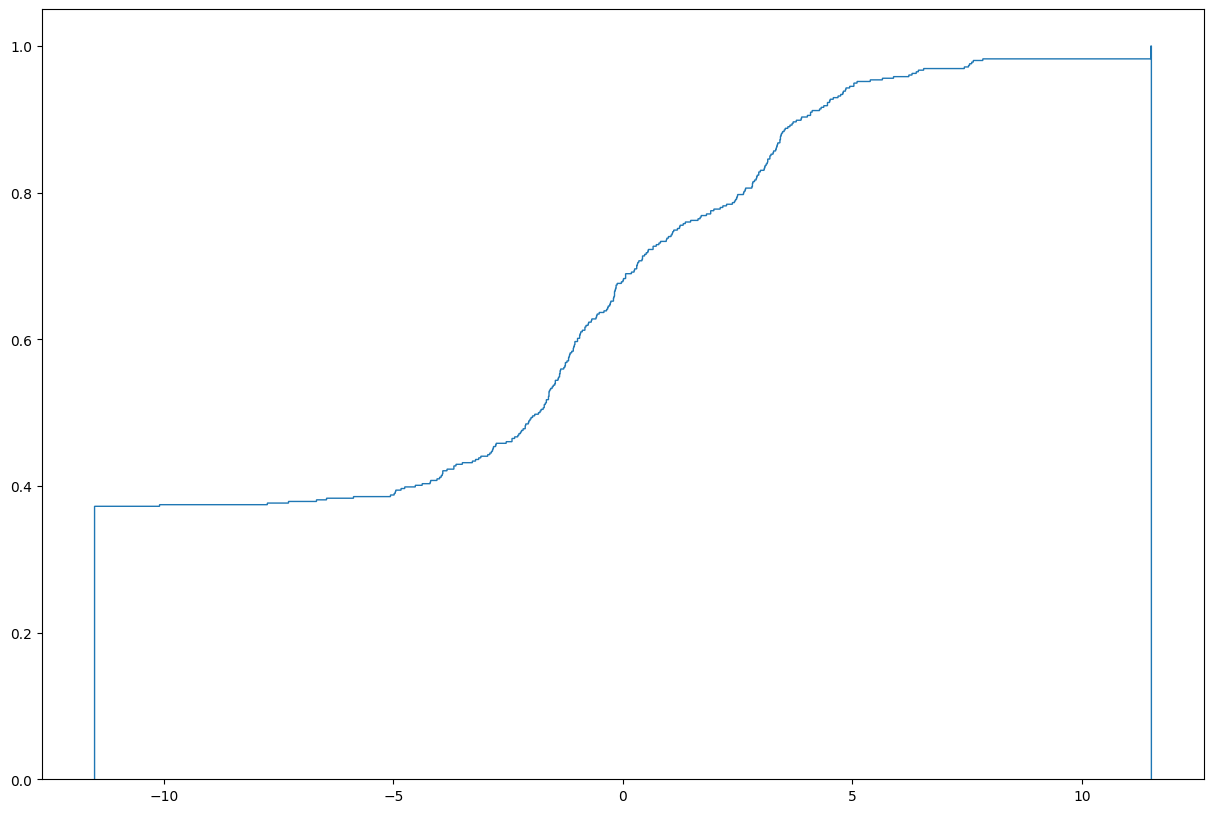

In [35]:
pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=250,
    numberofVars=1,
    numberofYs=1,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=8,
    n_head=8,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
).to(device)


print(train_dataset.itos)

model_path = "/content/drive/MyDrive/Colab Notebooks/STAT946_proj/models/best_model_119.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

test_results = run_and_plot(model, test_loader, textTest, train_dataset, device, pconfig)